In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# on workload C
throughput = [918.27,101.27,267.45]
latency = [1089,9874,3739]
db = ['mongo', 'sql', 'cassandra']

Text(0.5, 1.0, 'YCSB Throughput')

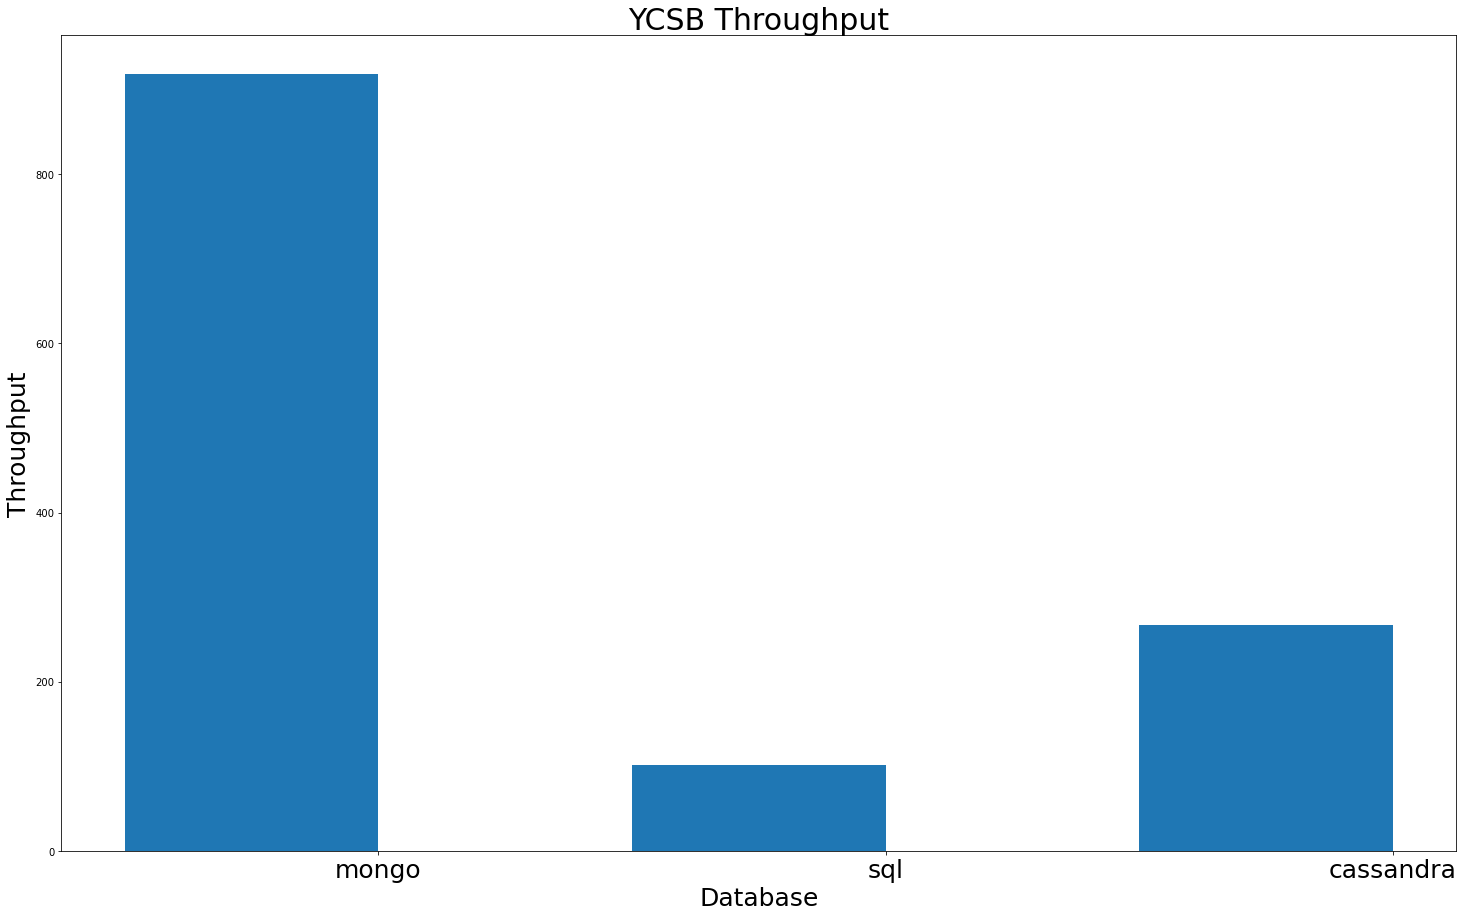

In [33]:
width = 0.5
x = np.arange(len(db))
plt.bar(x - width/2, throughput, width, label='Throughput')
plt.xticks(x, db, fontsize = 25)
plt.xlabel('Database', fontsize = 25)
plt.ylabel('Throughput', fontsize = 25)
plt.title('YCSB Throughput', fontsize = 30)


Text(0.5, 1.0, 'YCSB Latency')

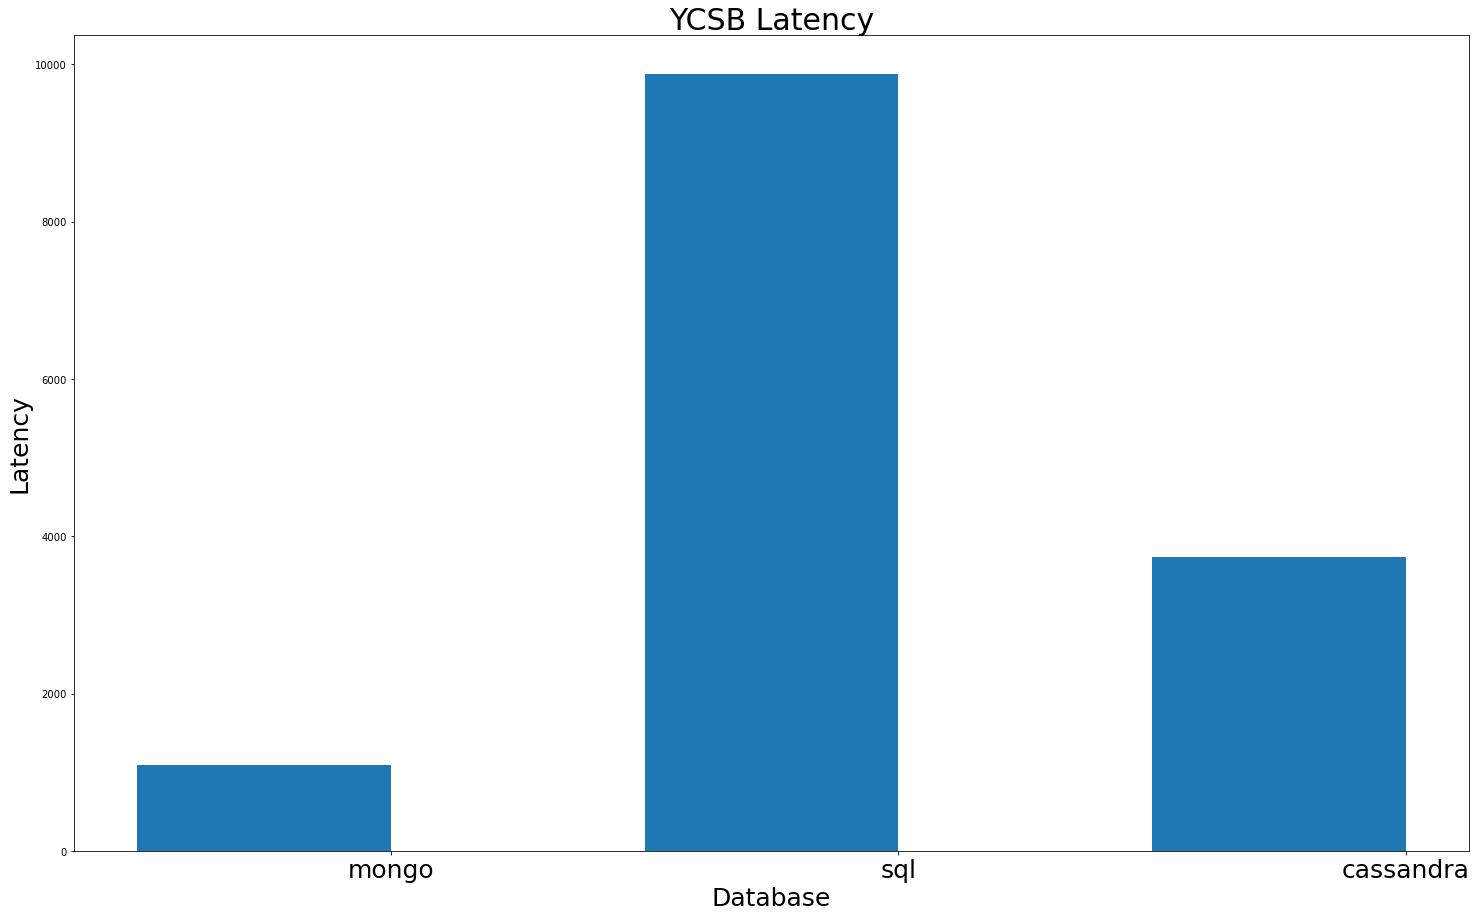

In [34]:
width = 0.5
x = np.arange(len(db))
plt.bar(x - width/2, latency, width, label='latency')
plt.xticks(x, db, fontsize = 25)
plt.xlabel('Database', fontsize = 25)
plt.ylabel('Latency', fontsize = 25)
plt.title('YCSB Latency', fontsize = 30)

In [1]:
from cassandra.cluster import Cluster
from cassandra.query import SimpleStatement
import pyarrow as pa
import csv
import subprocess

cluster = Cluster(['127.0.0.1'])
session = cluster.connect()

#os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.datastax.spark:spark-cassandra-connector_2.12:3.1.0 pyspark-shell'

#spark = SparkSession.builder.appName('SparkCassandraApp').master("local[*]").getOrCreate()
import warnings
warnings.filterwarnings('ignore')

In [2]:
KeyspaceName = 'ukrainetweets'
TableName = 'RawTweet'
session.set_keyspace(KeyspaceName)
#session.execute(f'DROP TABLE {TableName}')

In [3]:
import os
import csv
import gzip
from cassandra.cluster import Cluster
import pandas as pd


ReplicationOptions = {'class': 'SimpleStrategy', 'replication_factor': 1}

query = f"CREATE KEYSPACE IF NOT EXISTS {KeyspaceName} WITH REPLICATION = {ReplicationOptions}"
session.execute(query)

TableName = 'RawTweet'
ColumnNames = ["num", "userid","username","acctdesc","location","following","followers","totaltweets","usercreatedts","tweetid","tweetcreatedts","retweetcount","text","hashtags","language","coordinates","favorite_count","is_retweet","original_tweet_id","original_tweet_userid","original_tweet_username","in_reply_to_status_id","in_reply_to_user_id","in_reply_to_screen_name","is_quote_status","quoted_status_id","quoted_status_userid","quoted_status_username","extractedts"]

create_table = f"CREATE TABLE IF NOT EXISTS {KeyspaceName}.{TableName} (num TEXT, userid TEXT, username TEXT, acctdesc TEXT, location TEXT, following TEXT, followers TEXT, totaltweets TEXT, usercreatedts TIMESTAMP, tweetid TEXT PRIMARY KEY, tweetcreatedts TIMESTAMP, retweetcount TEXT, text TEXT, hashtags TEXT, language TEXT, coordinates TEXT, favorite_count TEXT, is_retweet TEXT, original_tweet_id TEXT, original_tweet_userid TEXT, original_tweet_username TEXT, in_reply_to_status_id TEXT, in_reply_to_user_id TEXT, in_reply_to_screen_name TEXT, is_quote_status TEXT, quoted_status_id TEXT, quoted_status_userid TEXT, quoted_status_username TEXT, extractedts TEXT)"
session.execute(create_table)






In [3]:
direct = '/home/hduser/Desktop/CA2/CA2'
I = 0
tweets = []
keywords = ['refugee', 'refugees', 'asylum', 'asylum seeker', 'asylum seeking', 'migration', 'refugee crisis']
for file in os.listdir(direct):
    I+=1
    print(I)
    if file.endswith('.csv.gzip'):
        path = os.path.join(direct, file)
        
        with gzip.open(path, 'rt', encoding = 'utf-8') as file:
            reader = csv.reader(file)
            header = next(reader)
            text_index = header.index('text')
            for row in reader:
                if any(keyword in row[text_index].lower() for keyword in keywords):
                    tweets.append(row)
        
df = pd.DataFrame(tweets)
df.head()

df.to_csv('Filtered_Tweets.csv', index = False)

#The cassandra drivers seem to not support the copy command so this was done in the terminal using the following command
'''
COPY RawTweet (num, userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,retweetcount,text,hashtags,language,coordinates,favorite_count,is_retweet,original_tweet_id,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,extractedts)FROM '/home/hduser/Desktop/CA2/Filtered_Tweets.csv'

'''

1


NameError: name 'gzip' is not defined

Number of reccords in the cassandra database

In [3]:
count = session.execute('SELECT COUNT(*) FROM RawTweet')
print(count[0])

Row(count=504771)


In [4]:
spark

In [5]:
from pyspark.sql.functions import col, to_timestamp
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
#import pyspark_cassandra
#pyspark --packages com.datastax.spark:spark-cassandra-connector_2.12:3.1.0

#spark.conf.set(s"spark.sql.catalog.cass100", "com.datastax.spark.connector.datasource.CassandraCatalog")
#spark.conf.set(s"spark.sql.catalog.cass100.spark.cassandra.connection.host", "127.0.0.100")

In [6]:
refugee = spark.read.format("org.apache.spark.sql.cassandra").options(table='rawtweet', keyspace=KeyspaceName).load().select("tweetid", "tweetcreatedts", "text", "language", "location")
#df = refugee.toPandas()

#from dateutil.parser import parse

#df['tweetcreatedts'] = df['tweetcreatedts'].apply(lambda x: parse(x))
#df.info()

In [7]:
refugee.sample(False, 0.2, 42)
refugee.show(20)

+-------------------+-------------------+--------------------+--------+--------------------+
|            tweetid|     tweetcreatedts|                text|language|            location|
+-------------------+-------------------+--------------------+--------+--------------------+
|1522348287931658242|2022-05-05 23:51:30|.@U24_gov_ua I wa...|      en|                null|
|1498776683259830272|2022-03-01 21:46:21|It’s notable that...|      en|                null|
|1509305387794812938|2022-03-31 00:03:40|More than 4 milli...|      en| Guadalajara, Mexico|
|1507141509694509057|2022-03-24 23:45:11|So the Chancellor...|      en|            SCOTLAND|
|1509127340969836552|2022-03-30 12:16:10|🆕 Council of Eur...|      en|  Strasbourg, France|
|1520557920223596544|2022-05-01 01:17:13|Putin’s illegal w...|      en|                null|
|1505068333250404357|2022-03-19 06:27:08|UK refugee host f...|      en|     Southeast Asia |
|1510346161290313734|2022-04-02 20:59:20|Join me for a spe...|      en|

2023-05-26 15:31:13,234 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=8864834353737856250, "partition key token"=9206246012205286067]' generated server side warning(s): Read 1000 live rows and 9099 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > 8864834353737856250 AND token(tweetid) <= 9206246012205286067 LIMIT 1000; token 8902158036330502941 (see tombstone_warn_threshold)
2023-05-26 15:31:13,247 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=8864834353737856250, "partition key token"=9206246012205286067]' generated server side warning(s):

In [8]:
#remove non english comments
from pyspark.sql.functions import col
refugee = refugee.filter(col('language') == 'en')
refugee.show(20)


+-------------------+-------------------+--------------------+--------+--------------------+
|            tweetid|     tweetcreatedts|                text|language|            location|
+-------------------+-------------------+--------------------+--------+--------------------+
|1536315923090612225|2022-06-13 12:53:54|This proposal of ...|      en|CheshireEngland/A...|
|1626190816623427586|2023-02-16 12:04:38|@s_sparwasser @Si...|      en|    Ottawa & Leipzig|
|1551611976731738112|2022-07-25 17:54:57|Ten British paedo...|      en|              DC-ish|
|1504515175730356227|2022-03-17 17:49:05|The scale of dest...|      en|                null|
|1514528960113086472|2022-04-14 10:00:17|Interacted with o...|      en|                null|
|1508307506698719239|2022-03-28 05:58:27|Avi Schiffmann is...|      en|                null|
|1505076436629004289|2022-03-19 06:59:20|TFW Prince Harry ...|      en|                null|
|1499732156284870664|2022-03-04 13:03:04|Polish border wit...|      en

2023-05-26 15:31:13,577 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=597104534163908440, "partition key token"=1777100034904740757]' generated server side warning(s): Read 1000 live rows and 9037 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > 597104534163908440 AND token(tweetid) <= 1777100034904740757 LIMIT 1000; token 633587450025600596 (see tombstone_warn_threshold)
2023-05-26 15:31:13,593 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=597104534163908440, "partition key token"=1777100034904740757]' generated server side warning(s): Rea

In [9]:
from pyspark.sql.functions import udf, lower, col, regexp_replace, concat_ws
from pyspark.sql.types import StringType, FloatType
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')  # for tokenization
nltk.download('wordnet')  # for lemmatization
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/hduser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hduser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/hduser/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
#remove retweets
refugee = refugee.filter(~col('text').rlike('RT @%'))
#make lower case
refugee = refugee.withColumn('text', lower(col('text')))
#removing twitter name
refugee = refugee.withColumn('text', regexp_replace(col('text'), '@[^\s]+', ''))
#removing hashtag
refugee = refugee.withColumn('text', regexp_replace(col('text'), '\\\B#\\S+', ''))
#removing special characters nums and punctuation
refugee = refugee.withColumn('text', regexp_replace(col('text'), '[^A-Za-z0-9 ]+', ''))
#remove single characters
refugee = refugee.withColumn('text', regexp_replace(col('text'), '\\s+[a-zA-Z]\\s+', ''))

#Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    words = nltk.word_tokenize(text)
    lemmatized = ' '.join([lemmatizer.lemmatize(word) for word in words])
    return lemmatized
#make into udf
lemmatize_udf = udf(lemmatize, StringType())
refugee = refugee.withColumn('text', lemmatize_udf('text'))
#Tokenize words, this is done as the stop words remover needs an array of words
tokenizer = Tokenizer(inputCol="text", outputCol="words")
refugee = tokenizer.transform(refugee)
# Removing stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
refugee = remover.transform(refugee)

#recombine the words into text
refugee = refugee.withColumn('text', concat_ws(' ', col("filtered_words")))


In [11]:
refugee.show(20)

2023-05-26 15:31:16,691 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-5746602870778827712, "partition key token"=-4708906719179708351]' generated server side warning(s): Read 1000 live rows and 8708 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > -5746602870778827712 AND token(tweetid) <= -4708906719179708351 LIMIT 1000; token -5709893955163087238 (see tombstone_warn_threshold)
2023-05-26 15:31:16,703 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-5746602870778827712, "partition key token"=-4708906719179708351]' generated server side warn

+-------------------+-------------------+--------------------+--------+-------------------+--------------------+--------------------+
|            tweetid|     tweetcreatedts|                text|language|           location|               words|      filtered_words|
+-------------------+-------------------+--------------------+--------+-------------------+--------------------+--------------------+
|1500235095671779333|2022-03-05 22:21:34|14 support ukrain...|      en| Destination • Moon|[14, support, for...|[14, support, ukr...|
|1504507440284717058|2022-03-17 17:18:20|crueltyputin murd...|      en|      United States|[crueltyputin, is...|[crueltyputin, mu...|
|1507251918162247680|2022-03-25 07:03:55|two million ukrai...|      en|Geneva, Switzerland|[more, than, two,...|[two, million, uk...|
|1541318735365029891|2022-06-27 08:13:17|455 ammorning dni...|      en|         Erith Kent|[455, ammorning, ...|[455, ammorning, ...|
|1505762697602043905|2022-03-21 04:26:17|amp mila kunis am...|

2023-05-26 15:31:17,667 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-5746602870778827712, "partition key token"=-4708906719179708351]' generated server side warning(s): Read 1000 live rows and 9033 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1536573278462042113) AND token(tweetid) <= -4708906719179708351 LIMIT 1000; token -5160514479457060090 (see tombstone_warn_threshold)
2023-05-26 15:31:17,685 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-5746602870778827712, "partition key token"=-4708906719179708351]' generated server sid

In [12]:
!pip install vaderSentiment

Defaulting to user installation because normal site-packages is not writeable


In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [14]:
def sentiment(text):
    sentiment_analy = SentimentIntensityAnalyzer()
    vader = sentiment_analy.polarity_scores(text)
    return float(vader['compound'])
    

In [15]:
udfSentiment = udf(sentiment, FloatType())
refugee = refugee.withColumn('sentiment_polarity', udfSentiment('text'))
refugee.persist()
refugee.show(20)


2023-05-26 15:31:20,290 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-3857806206306463357, "partition key token"=-3006705693433218363]' generated server side warning(s): Read 1000 live rows and 9161 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > -3857806206306463357 AND token(tweetid) <= -3006705693433218363 LIMIT 1000; token -3821743335361541600 (see tombstone_warn_threshold)
2023-05-26 15:31:20,300 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-3857806206306463357, "partition key token"=-3006705693433218363]' generated server side warn

2023-05-26 15:31:21,280 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-3857806206306463357, "partition key token"=-3006705693433218363]' generated server side warning(s): Read 1000 live rows and 8855 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1505149865982054400) AND token(tweetid) <= -3006705693433218363 LIMIT 1000; token -3278498192549406327 (see tombstone_warn_threshold)
2023-05-26 15:31:21,296 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-3857806206306463357, "partition key token"=-3006705693433218363]' generated server sid

+-------------------+-------------------+--------------------+--------+--------------------+--------------------+--------------------+------------------+
|            tweetid|     tweetcreatedts|                text|language|            location|               words|      filtered_words|sentiment_polarity|
+-------------------+-------------------+--------------------+--------+--------------------+--------------------+--------------------+------------------+
|1502648731740606467|2022-03-12 14:12:30|share website hel...|      en|    New York, USA   |[can, you, share,...|[share, website, ...|             0.802|
|1517060765525680128|2022-04-21 09:40:46|together construc...|      en|                null|[together, with, ...|[together, constr...|           -0.1779|
|1522547053645254659|2022-05-06 13:01:19|tenacious staying...|      en|          Toronto ON|[the, tenacious, ...|[tenacious, stayi...|           -0.2263|
|1498731089023676422|2022-03-01 18:45:11|notable comedian ...|      en|     

In [16]:
#maker functioin to catagorize sentiment
def sentiment_cat(sentiment):
    if sentiment <= -0.6:
        return "Negative"
    elif -0.6 < sentiment <= -0.2:
        return "Ngative-ish"
    elif -0.2 < sentiment <= 0.2:
        return "Neutral"
    elif 0.2 < sentiment <= 0.6:
        return "Positive-ish"
    else:
        return "Positive"
sentiment_cat_udf = udf(sentiment_cat, StringType())
refugee = refugee.withColumn('Sentiment_Category', sentiment_cat_udf('sentiment_polarity'))
refugee.persist()
refugee.show()


+-------------------+-------------------+--------------------+--------+--------------------+--------------------+--------------------+------------------+------------------+
|            tweetid|     tweetcreatedts|                text|language|            location|               words|      filtered_words|sentiment_polarity|Sentiment_Category|
+-------------------+-------------------+--------------------+--------+--------------------+--------------------+--------------------+------------------+------------------+
|1502648731740606467|2022-03-12 14:12:30|share website hel...|      en|    New York, USA   |[can, you, share,...|[share, website, ...|             0.802|          Positive|
|1517060765525680128|2022-04-21 09:40:46|together construc...|      en|                null|[together, with, ...|[together, constr...|           -0.1779|           Neutral|
|1522547053645254659|2022-05-06 13:01:19|tenacious staying...|      en|          Toronto ON|[the, tenacious, ...|[tenacious, stayi...| 

2023-05-26 15:12:36,754 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-3857806206306463357, "partition key token"=-3006705693433218363]' generated server side warning(s): Read 1000 live rows and 9161 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > -3857806206306463357 AND token(tweetid) <= -3006705693433218363 LIMIT 1000; token -3821743335361541600 (see tombstone_warn_threshold)
2023-05-26 15:12:36,768 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=8864834353737856250, "partition key token"=9206246012205286067]' generated server side warnin

2023-05-26 15:12:36,872 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-8502103768276032744, "partition key token"=-7643201395326989908]' generated server side warning(s): Read 1000 live rows and 8898 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1503396437752782848) AND token(tweetid) <= -7643201395326989908 LIMIT 1000; token -8393888733716820013 (see tombstone_warn_threshold)
2023-05-26 15:12:36,899 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-4708906719179708351, "partition key token"=-3857806206306463357]' generated server sid

2023-05-26 15:12:37,476 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=8864834353737856250, "partition key token"=9206246012205286067]' generated server side warning(s): Read 1000 live rows and 8723 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1504979728830193664) AND token(tweetid) <= 9206246012205286067 LIMIT 1000; token 9048922743325383590 (see tombstone_warn_threshold)
2023-05-26 15:12:37,507 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-333550264548054545, "partition key token"=549362640592366918]' generated server side warni

2023-05-26 15:12:37,768 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-333550264548054545, "partition key token"=549362640592366918]' generated server side warning(s): Read 1000 live rows and 9004 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1502936592092180482) AND token(tweetid) <= 549362640592366918 LIMIT 1000; token -38073657499308712 (see tombstone_warn_threshold)
2023-05-26 15:12:37,785 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-8502103768276032744, "partition key token"=-7643201395326989908]' generated server side warni

2023-05-26 15:12:37,988 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-333550264548054545, "partition key token"=549362640592366918]' generated server side warning(s): Read 1000 live rows and 8949 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1513596457751875590) AND token(tweetid) <= 549362640592366918 LIMIT 1000; token 73199082031652063 (see tombstone_warn_threshold)
2023-05-26 15:12:37,989 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-3857806206306463357, "partition key token"=-3006705693433218363]' generated server side warnin

2023-05-26 15:12:38,191 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=597104534163908440, "partition key token"=1777100034904740757]' generated server side warning(s): Read 1000 live rows and 9114 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1513057967624568832) AND token(tweetid) <= 1777100034904740757 LIMIT 1000; token 950197724505924962 (see tombstone_warn_threshold)
2023-05-26 15:12:38,202 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-333550264548054545, "partition key token"=549362640592366918]' generated server side warning

2023-05-26 15:12:38,408 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-4708906719179708351, "partition key token"=-3857806206306463357]' generated server side warning(s): Read 1000 live rows and 8726 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1505914795765211139) AND token(tweetid) <= -3857806206306463357 LIMIT 1000; token -4227430490755938667 (see tombstone_warn_threshold)
2023-05-26 15:12:38,409 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=597104534163908440, "partition key token"=1777100034904740757]' generated server side w

2023-05-26 15:12:38,611 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-7643201395326989908, "partition key token"=-6784299022377947072]' generated server side warning(s): Read 1000 live rows and 8880 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1518878525842993152) AND token(tweetid) <= -6784299022377947072 LIMIT 1000; token -7053514194645853075 (see tombstone_warn_threshold)
2023-05-26 15:12:38,620 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-333550264548054545, "partition key token"=549362640592366918]' generated server side w

2023-05-26 15:12:39,130 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-8502103768276032744, "partition key token"=-7643201395326989908]' generated server side warning(s): Read 1000 live rows and 8953 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1540651025895407616) AND token(tweetid) <= -7643201395326989908 LIMIT 1000; token -7765874425983571654 (see tombstone_warn_threshold)
2023-05-26 15:12:39,130 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=597104534163908440, "partition key token"=1777100034904740757]' generated server side w

2023-05-26 15:12:39,401 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-7643201395326989908, "partition key token"=-6784299022377947072]' generated server side warning(s): Read 502 live rows and 4469 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1590531338204897281) AND token(tweetid) <= -6784299022377947072 LIMIT 1000; token -6784305093397465660 (see tombstone_warn_threshold)
2023-05-26 15:12:39,408 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-8502103768276032744, "partition key token"=-7643201395326989908]' generated server side

2023-05-26 15:12:39,682 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=7287974239996140842, "partition key token"=7447475080679012599]' generated server side warning(s): Read 1000 live rows and 8829 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1505151936827428876) AND token(tweetid) <= 7447475080679012599 LIMIT 1000; token 7398007524066175842 (see tombstone_warn_threshold)
2023-05-26 15:12:39,696 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-4708906719179708351, "partition key token"=-3857806206306463357]' generated server side wa

2023-05-26 15:12:40,109 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=597104534163908440, "partition key token"=1777100034904740757]' generated server side warning(s): Read 782 live rows and 6913 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1532469539069382656) AND token(tweetid) <= 1777100034904740757 LIMIT 1000; token 1777071454282627313 (see tombstone_warn_threshold)
2023-05-26 15:13:25,481 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=8024891708407858539, "partition key token"=8864834353737856250]' generated server side warnin

2023-05-26 15:13:25,947 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=8024891708407858539, "partition key token"=8864834353737856250]' generated server side warning(s): Read 1000 live rows and 8959 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1514191186168328198) AND token(tweetid) <= 8864834353737856250 LIMIT 1000; token 8499620462073207135 (see tombstone_warn_threshold)
2023-05-26 15:13:25,986 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=8024891708407858539, "partition key token"=8864834353737856250]' generated server side warn

2023-05-26 15:13:48,146 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-8735660358072060172, "partition key token"=-8729112070729447134]' generated server side warning(s): Read 182 live rows and 1594 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > -8735660358072060172 AND token(tweetid) <= -8729112070729447134 LIMIT 1000; token -8729163054248058214 (see tombstone_warn_threshold)
2023-05-26 15:13:48,162 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=6290893419579972605, "partition key token"=7287974239996140842]' generated server side warning

2023-05-26 15:13:48,643 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=6290893419579972605, "partition key token"=7287974239996140842]' generated server side warning(s): Read 1000 live rows and 8645 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1500458867511246850) AND token(tweetid) <= 7287974239996140842 LIMIT 1000; token 6879671670897926926 (see tombstone_warn_threshold)
2023-05-26 15:13:48,672 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=6290893419579972605, "partition key token"=7287974239996140842]' generated server side warn

2023-05-26 15:14:28,599 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-6784299022377947072, "partition key token"=-5746602870778827712]' generated server side warning(s): Read 1000 live rows and 8804 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > -6784299022377947072 AND token(tweetid) <= -5746602870778827712 LIMIT 1000; token -6747961037251815877 (see tombstone_warn_threshold)
2023-05-26 15:14:28,610 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-6784299022377947072, "partition key token"=-5746602870778827712]' generated server side warn

2023-05-26 15:14:29,271 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-6784299022377947072, "partition key token"=-5746602870778827712]' generated server side warning(s): Read 1000 live rows and 8996 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1511683005416366084) AND token(tweetid) <= -5746602870778827712 LIMIT 1000; token -6126483074655355641 (see tombstone_warn_threshold)
2023-05-26 15:14:29,297 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-6784299022377947072, "partition key token"=-5746602870778827712]' generated server sid

2023-05-26 15:14:31,452 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=2957095535645573075, "partition key token"=3950434624964232779]' generated server side warning(s): Read 1000 live rows and 8805 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1522570096765550593) AND token(tweetid) <= 3950434624964232779 LIMIT 1000; token 3104824179572831824 (see tombstone_warn_threshold)
2023-05-26 15:14:31,504 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=2957095535645573075, "partition key token"=3950434624964232779]' generated server side warn

2023-05-26 15:14:31,882 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=1777100034904740757, "partition key token"=2957095535645573075]' generated server side warning(s): Read 1000 live rows and 8841 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1504303951071522819) AND token(tweetid) <= 2957095535645573075 LIMIT 1000; token 2035022801864924234 (see tombstone_warn_threshold)
2023-05-26 15:14:31,902 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=1777100034904740757, "partition key token"=2957095535645573075]' generated server side warn

2023-05-26 15:14:32,303 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=1777100034904740757, "partition key token"=2957095535645573075]' generated server side warning(s): Read 1000 live rows and 8658 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1518897961572478976) AND token(tweetid) <= 2957095535645573075 LIMIT 1000; token 2404841078034093571 (see tombstone_warn_threshold)
2023-05-26 15:14:32,336 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=1777100034904740757, "partition key token"=2957095535645573075]' generated server side warn

2023-05-26 15:14:32,758 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=1777100034904740757, "partition key token"=2957095535645573075]' generated server side warning(s): Read 1000 live rows and 8801 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1533036285421670400) AND token(tweetid) <= 2957095535645573075 LIMIT 1000; token 2846560647894220389 (see tombstone_warn_threshold)
2023-05-26 15:14:32,783 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=1777100034904740757, "partition key token"=2957095535645573075]' generated server side warn

2023-05-26 15:14:35,208 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-5746602870778827712, "partition key token"=-4708906719179708351]' generated server side warning(s): Read 1000 live rows and 8983 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1509168596676603906) AND token(tweetid) <= -4708906719179708351 LIMIT 1000; token -5235388175446788322 (see tombstone_warn_threshold)
2023-05-26 15:14:35,245 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-5746602870778827712, "partition key token"=-4708906719179708351]' generated server sid

2023-05-26 15:14:52,691 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-2025346008244648701, "partition key token"=-1627592203720613618]' generated server side warning(s): Read 1000 live rows and 8968 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > -2025346008244648701 AND token(tweetid) <= -1627592203720613618 LIMIT 1000; token -1988037727563398932 (see tombstone_warn_threshold)
2023-05-26 15:14:52,762 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-2025346008244648701, "partition key token"=-1627592203720613618]' generated server side warn

2023-05-26 15:14:53,116 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=7447475080679012599, "partition key token"=8024891708407858539]' generated server side warning(s): Read 1000 live rows and 8974 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1510890111575203840) AND token(tweetid) <= 8024891708407858539 LIMIT 1000; token 7666702312489986730 (see tombstone_warn_threshold)
2023-05-26 15:14:53,148 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=7447475080679012599, "partition key token"=8024891708407858539]' generated server side warn

2023-05-26 15:15:11,806 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-746951677686615280, "partition key token"=-333550264548054545]' generated server side warning(s): Read 1000 live rows and 9106 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1518529643736977408) AND token(tweetid) <= -333550264548054545 LIMIT 1000; token -529617142644584381 (see tombstone_warn_threshold)
2023-05-26 15:15:11,850 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-746951677686615280, "partition key token"=-333550264548054545]' generated server side warn

2023-05-26 15:15:12,248 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-2466941506363674373, "partition key token"=-2025346008244648701]' generated server side warning(s): Read 1000 live rows and 8970 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1528712593711345666) AND token(tweetid) <= -2025346008244648701 LIMIT 1000; token -2179206076320727801 (see tombstone_warn_threshold)
2023-05-26 15:15:12,294 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-2466941506363674373, "partition key token"=-2025346008244648701]' generated server sid

2023-05-26 15:15:18,243 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=4984104007690344316, "partition key token"=6017773390416455853]' generated server side warning(s): Read 1000 live rows and 8870 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1498357258660552707) AND token(tweetid) <= 6017773390416455853 LIMIT 1000; token 5460172345047101268 (see tombstone_warn_threshold)
2023-05-26 15:15:18,291 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=4984104007690344316, "partition key token"=6017773390416455853]' generated server side warn

2023-05-26 15:15:49,033 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=3950434624964232779, "partition key token"=4984104007690344316]' generated server side warning(s): Read 1000 live rows and 8706 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > 3950434624964232779 AND token(tweetid) <= 4984104007690344316 LIMIT 1000; token 3986833380027797326 (see tombstone_warn_threshold)
2023-05-26 15:15:49,047 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=3950434624964232779, "partition key token"=4984104007690344316]' generated server side warning(s):

2023-05-26 15:15:49,499 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=3950434624964232779, "partition key token"=4984104007690344316]' generated server side warning(s): Read 1000 live rows and 8929 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1536843578198089728) AND token(tweetid) <= 4984104007690344316 LIMIT 1000; token 4499676296471895514 (see tombstone_warn_threshold)
2023-05-26 15:15:49,527 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=3950434624964232779, "partition key token"=4984104007690344316]' generated server side warn

2023-05-26 15:16:31,653 WARN cql.CqlRequestHandler: Query '[1 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ?   ALLOW FILTERING ["partition key token"=9206246012205286067]' generated server side warning(s): Read 467 live rows and 4060 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > 9206246012205286067 LIMIT 1000; token 9223370470024647052 (see tombstone_warn_threshold)
2023-05-26 15:16:31,677 WARN cql.CqlRequestHandler: Query '[1 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-8735660358072060172]' generated server side warning(s): Read 1000 live rows and 8971 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) <= -8735660358072060172 LI

2023-05-26 15:16:32,299 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-972164765231508612, "partition key token"=-746951677686615280]' generated server side warning(s): Read 1000 live rows and 8806 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1517878222175809536) AND token(tweetid) <= -746951677686615280 LIMIT 1000; token -751200788758471296 (see tombstone_warn_threshold)
2023-05-26 15:16:37,488 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-1588021499126624084, "partition key token"=-972164765231508612]' generated server side war

2023-05-26 15:16:38,332 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-1588021499126624084, "partition key token"=-972164765231508612]' generated server side warning(s): Read 1000 live rows and 8850 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1528535006833831936) AND token(tweetid) <= -972164765231508612 LIMIT 1000; token -1077938649361995748 (see tombstone_warn_threshold)
2023-05-26 15:16:38,357 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-1588021499126624084, "partition key token"=-972164765231508612]' generated server side w

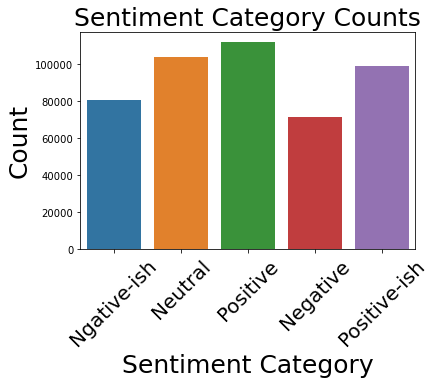

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the count of each sentiment category
sentiment_counts = refugee.groupBy('Sentiment_Category').count().toPandas()

# Set the color palette for the plot

# Create the bar plot
sns.barplot(data=sentiment_counts, x='Sentiment_Category', y='count')

# Set the title and labels
plt.title('Sentiment Category Counts', fontsize = 25)
plt.xlabel('Sentiment Category', fontsize = 25)
plt.ylabel('Count', fontsize = 25)

# Rotate the x-axis labels if needed
plt.xticks(rotation=45, fontsize = 20)

# Display the plot
plt.show()

2023-05-24 22:59:49,204 WARN memory.MemoryStore: Not enough space to cache rdd_38_3 in memory! (computed 32.3 MiB so far)
2023-05-24 22:59:49,284 WARN memory.MemoryStore: Not enough space to cache rdd_38_10 in memory! (computed 3.8 MiB so far)
2023-05-24 22:59:49,323 WARN memory.MemoryStore: Not enough space to cache rdd_38_8 in memory! (computed 28.5 MiB so far)
2023-05-24 22:59:49,362 WARN memory.MemoryStore: Not enough space to cache rdd_38_14 in memory! (computed 28.5 MiB so far)
2023-05-24 22:59:49,362 WARN memory.MemoryStore: Not enough space to cache rdd_38_16 in memory! (computed 23.7 MiB so far)
2023-05-24 22:59:49,363 WARN memory.MemoryStore: Not enough space to cache rdd_38_12 in memory! (computed 28.6 MiB so far)
2023-05-24 22:59:49,746 WARN memory.MemoryStore: Not enough space to cache rdd_38_3 in memory! (computed 32.3 MiB so far)
2023-05-24 22:59:49,827 WARN memory.MemoryStore: Not enough space to cache rdd_38_8 in memory! (computed 28.5 MiB so far)
2023-05-24 22:59:49,8

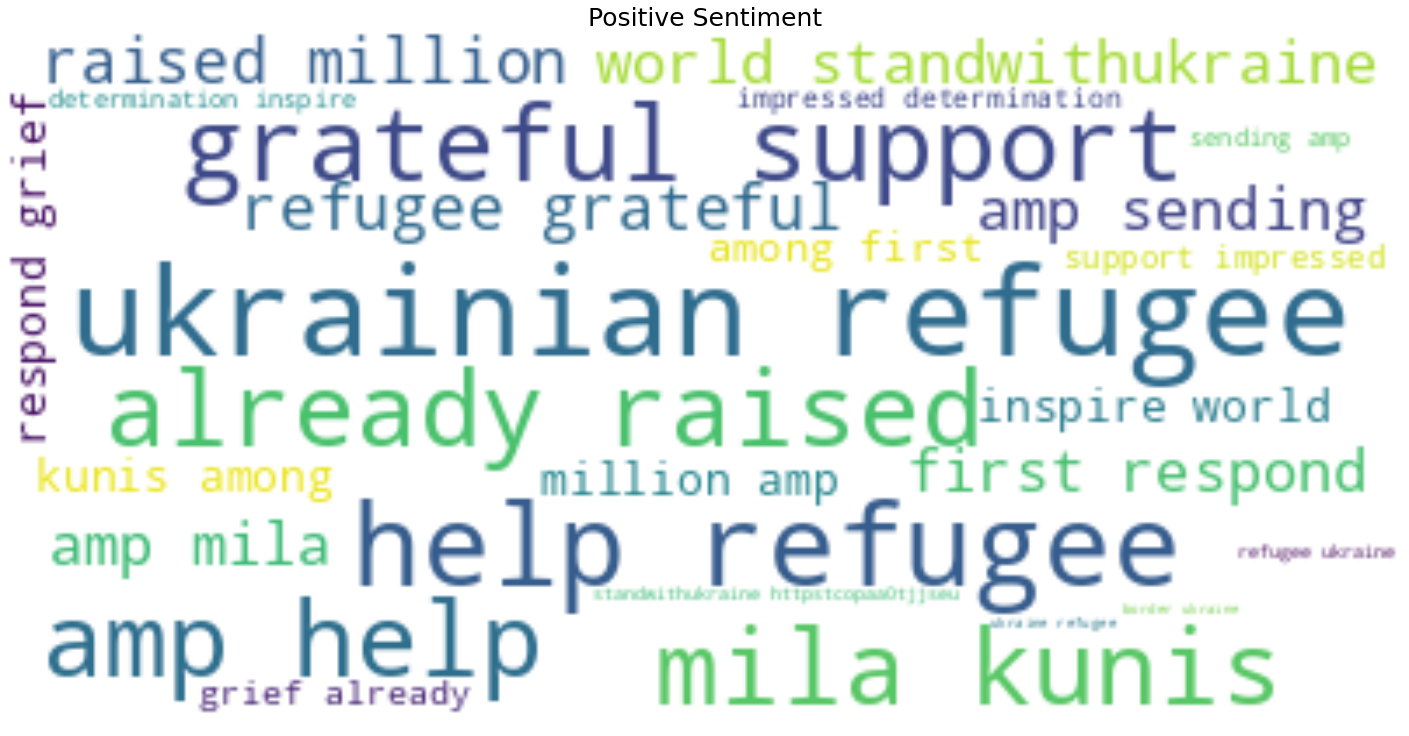

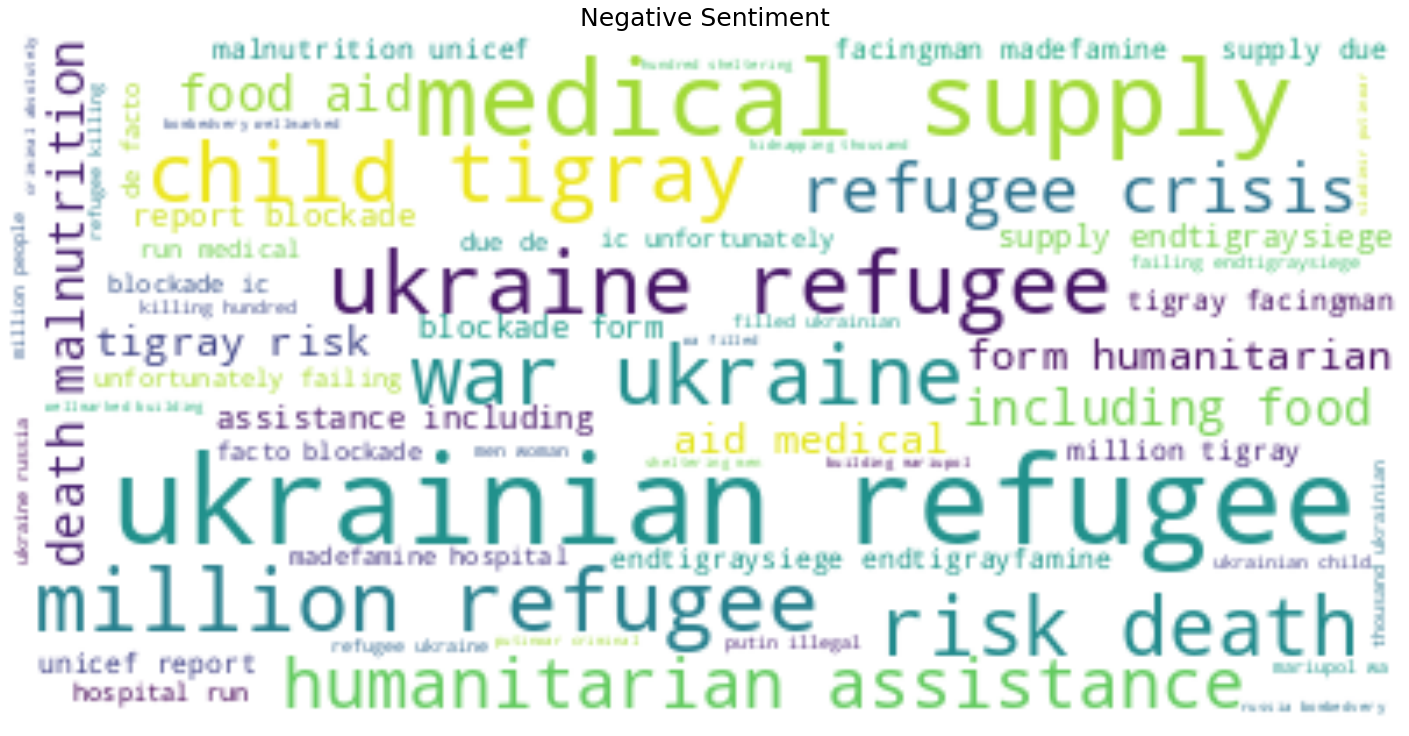

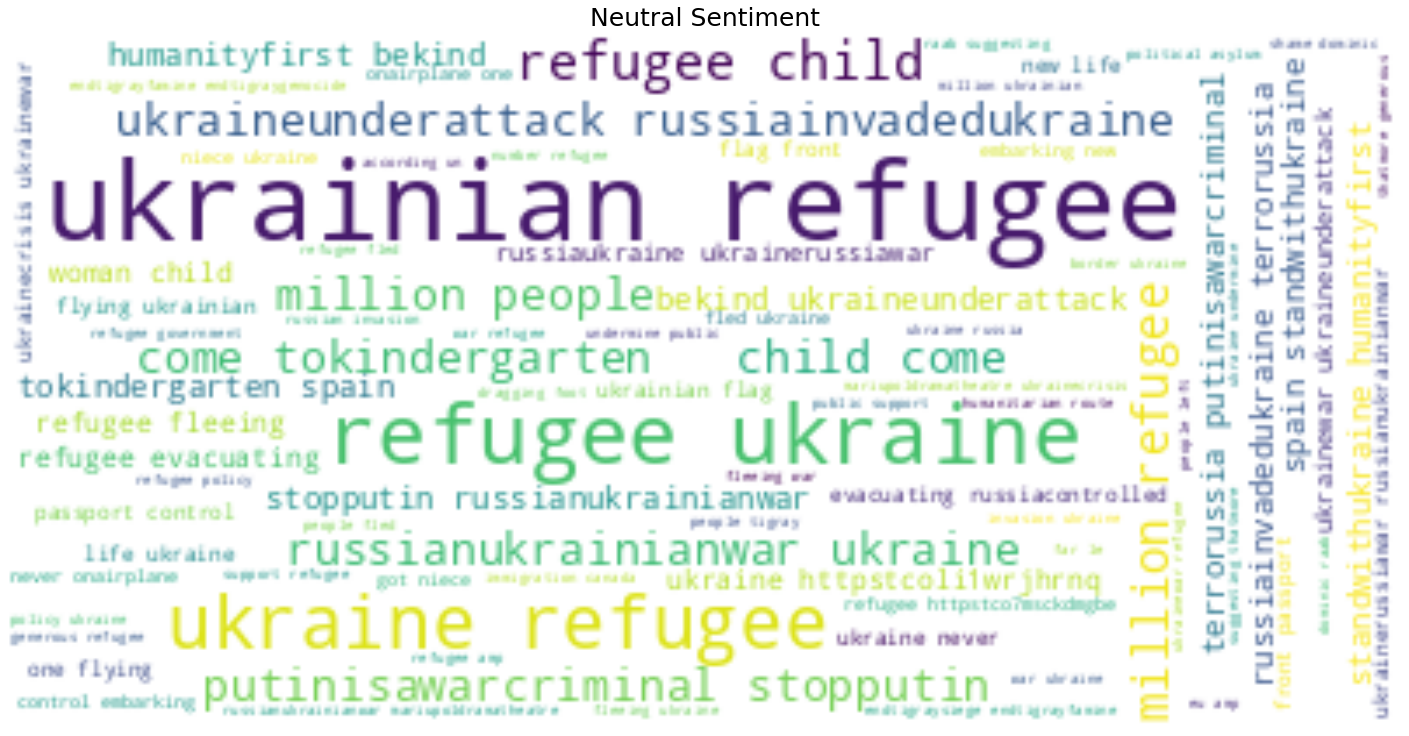

In [64]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.sql.functions import concat_ws

# Filter the DataFrame for positive sentiment
positive_df = refugee.filter(refugee['Sentiment_Category'] == 'Positive')
positive_text = ' '.join(positive_df.select(concat_ws(" ", positive_df['text'])).rdd.flatMap(lambda x: x).collect())

# Filter the DataFrame for negative sentiment
negative_df = refugee.filter(refugee['Sentiment_Category'] == 'Negative')
negative_text = ' '.join(negative_df.select(concat_ws(" ", negative_df['text'])).rdd.flatMap(lambda x: x).collect())

# Filter the DataFrame for neutral sentiment
neutral_df = refugee.filter(refugee['Sentiment_Category'] == 'Neutral')
neutral_text = ' '.join(neutral_df.select(concat_ws(" ", neutral_df['text'])).rdd.flatMap(lambda x: x).collect())

# Create word cloud for positive sentiment
positive_wordcloud = WordCloud(background_color='white').generate(positive_text)
plt.figure()
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment', fontsize = 25)
plt.axis('off')

# Create word cloud for negative sentiment
negative_wordcloud = WordCloud(background_color='white').generate(negative_text)
plt.figure()
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment', fontsize = 25)
plt.axis('off')

# Create word cloud for neutral sentiment
neutral_wordcloud = WordCloud(background_color='white').generate(neutral_text)
plt.figure()
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Neutral Sentiment', fontsize = 25)
plt.axis('off')

# Display the word clouds
plt.show()


2023-05-24 23:21:17,901 WARN memory.MemoryStore: Not enough space to cache rdd_38_3 in memory! (computed 32.3 MiB so far)
2023-05-24 23:21:18,065 WARN memory.MemoryStore: Not enough space to cache rdd_38_11 in memory! (computed 27.3 MiB so far)
2023-05-24 23:21:18,066 WARN memory.MemoryStore: Not enough space to cache rdd_38_8 in memory! (computed 28.5 MiB so far)
2023-05-24 23:21:18,269 WARN memory.MemoryStore: Not enough space to cache rdd_38_14 in memory! (computed 28.5 MiB so far)
2023-05-24 23:21:18,309 WARN memory.MemoryStore: Not enough space to cache rdd_38_18 in memory! (computed 17.0 MiB so far)
2023-05-24 23:21:18,529 WARN memory.MemoryStore: Not enough space to cache rdd_38_17 in memory! (computed 25.0 MiB so far)


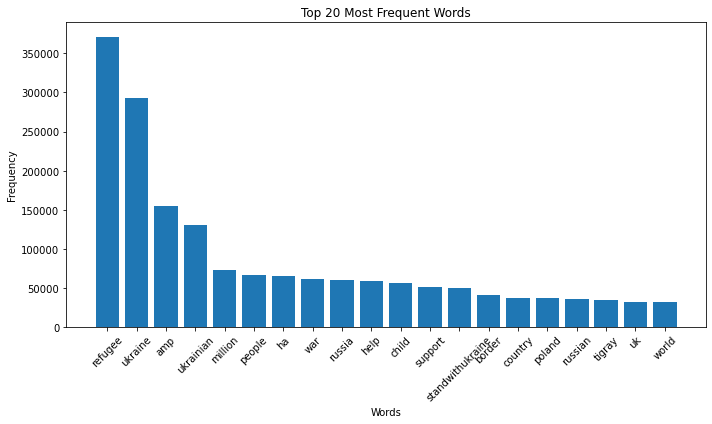

2023-05-24 23:21:22,982 WARN memory.MemoryStore: Not enough space to cache rdd_38_3 in memory! (computed 32.3 MiB so far)
2023-05-24 23:21:23,082 WARN memory.MemoryStore: Not enough space to cache rdd_38_8 in memory! (computed 28.5 MiB so far)
2023-05-24 23:21:23,108 WARN memory.MemoryStore: Not enough space to cache rdd_38_11 in memory! (computed 3.8 MiB so far)
2023-05-24 23:21:23,130 WARN memory.MemoryStore: Not enough space to cache rdd_38_18 in memory! (computed 3.8 MiB so far)
2023-05-24 23:21:23,131 WARN memory.MemoryStore: Not enough space to cache rdd_38_14 in memory! (computed 28.5 MiB so far)
2023-05-24 23:21:23,132 WARN memory.MemoryStore: Not enough space to cache rdd_38_17 in memory! (computed 3.8 MiB so far)


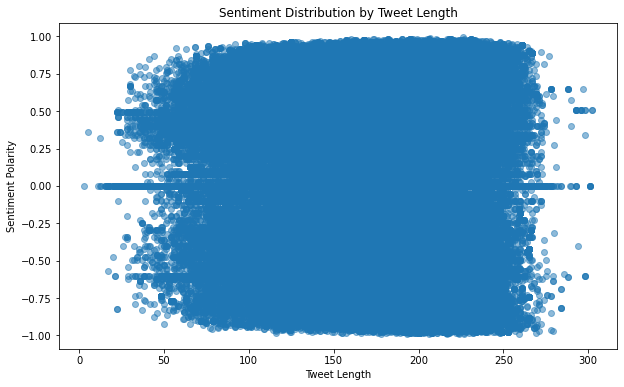

In [66]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from pyspark.sql.functions import length
from pyspark.sql.functions import col

# Word Frequency Analysis (Task 4)
# Convert the 'text' column to a single string
text_data = ' '.join(refugee.select('text').rdd.flatMap(lambda x: x).collect())

# Generate word frequency counts
word_counts = spark.createDataFrame([(word, count) for word, count in Counter(text_data.split()).items()], ['word', 'count'])

# Plot the top 20 most frequent words
top_words = word_counts.orderBy(col('count').desc()).limit(20).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_words['word'], top_words['count'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sentiment and Tweet Length Analysis (Task 8)
# Calculate the length of each tweet
refugee = refugee.withColumn('tweet_length', length(refugee['text']))

# Convert PySpark DataFrame to Pandas for plotting
refugee_pd = refugee.select('tweet_length', 'sentiment_polarity').toPandas()

# Plot sentiment distribution based on tweet length
plt.figure(figsize=(10, 6))
plt.scatter(refugee_pd['tweet_length'], refugee_pd['sentiment_polarity'], alpha=0.5)
plt.xlabel('Tweet Length')
plt.ylabel('Sentiment Polarity')
plt.title('Sentiment Distribution by Tweet Length')
plt.show()


In [20]:
del sentiment_counts
del top_words
del positive_df, negative_df, neutral_df

NameError: name 'top_words' is not defined

In [18]:
refugee.show(20)

2023-05-26 15:33:59,378 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=8024891708407858539, "partition key token"=8864834353737856250]' generated server side warning(s): Read 1000 live rows and 8975 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > 8024891708407858539 AND token(tweetid) <= 8864834353737856250 LIMIT 1000; token 8062028009575384022 (see tombstone_warn_threshold)
2023-05-26 15:33:59,379 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=8864834353737856250, "partition key token"=9206246012205286067]' generated server side warning(s):

2023-05-26 15:33:59,581 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=8024891708407858539, "partition key token"=8864834353737856250]' generated server side warning(s): Read 1000 live rows and 8939 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1513032339420499970) AND token(tweetid) <= 8864834353737856250 LIMIT 1000; token 8133816273896599947 (see tombstone_warn_threshold)
2023-05-26 15:33:59,520 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=597104534163908440, "partition key token"=1777100034904740757]' generated server side warni

2023-05-26 15:33:59,793 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-5746602870778827712, "partition key token"=-4708906719179708351]' generated server side warning(s): Read 1000 live rows and 8793 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1510530754534596610) AND token(tweetid) <= -4708906719179708351 LIMIT 1000; token -5637878172096978389 (see tombstone_warn_threshold)
2023-05-26 15:33:59,825 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=7447475080679012599, "partition key token"=8024891708407858539]' generated server side 

2023-05-26 15:34:00,036 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-5746602870778827712, "partition key token"=-4708906719179708351]' generated server side warning(s): Read 1000 live rows and 8686 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1510263529651253255) AND token(tweetid) <= -4708906719179708351 LIMIT 1000; token -5565213540720791592 (see tombstone_warn_threshold)
2023-05-26 15:34:00,060 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-2466941506363674373, "partition key token"=-2025346008244648701]' generated server sid

2023-05-26 15:34:00,471 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=6290893419579972605, "partition key token"=7287974239996140842]' generated server side warning(s): Read 1000 live rows and 8749 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1496941651834675203) AND token(tweetid) <= 7287974239996140842 LIMIT 1000; token 6656137107103914596 (see tombstone_warn_threshold)
2023-05-26 15:34:00,472 WARN cql.CqlRequestHandler: Query '[1 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ?   ALLOW FILTERING ["partition key token"=9206246012205286067]' generated server side warning(s): Read 467 live rows and 4060 tombstone cells for query SELECT 

2023-05-26 15:34:00,682 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=7447475080679012599, "partition key token"=8024891708407858539]' generated server side warning(s): Read 1000 live rows and 8759 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1504945617742704644) AND token(tweetid) <= 8024891708407858539 LIMIT 1000; token 7851586524559315232 (see tombstone_warn_threshold)
2023-05-26 15:34:00,694 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=597104534163908440, "partition key token"=1777100034904740757]' generated server side warni

2023-05-26 15:34:00,916 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=6290893419579972605, "partition key token"=7287974239996140842]' generated server side warning(s): Read 1000 live rows and 8862 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1509245803809886208) AND token(tweetid) <= 7287974239996140842 LIMIT 1000; token 6841255287681750611 (see tombstone_warn_threshold)
2023-05-26 15:34:00,917 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-8502103768276032744, "partition key token"=-7643201395326989908]' generated server side wa

2023-05-26 15:34:01,136 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=8024891708407858539, "partition key token"=8864834353737856250]' generated server side warning(s): Read 1000 live rows and 8874 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1498099974000812033) AND token(tweetid) <= 8864834353737856250 LIMIT 1000; token 8537062281776753409 (see tombstone_warn_threshold)
2023-05-26 15:34:01,151 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-8502103768276032744, "partition key token"=-7643201395326989908]' generated server side wa

2023-05-26 15:34:01,370 WARN cql.CqlRequestHandler: Query '[1 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-8735660358072060172]' generated server side warning(s): Read 1000 live rows and 8871 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1513944222759542790) AND token(tweetid) <= -8735660358072060172 LIMIT 1000; token -9000391648049989899 (see tombstone_warn_threshold)
2023-05-26 15:34:01,370 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-746951677686615280, "partition key token"=-333550264548054545]' generated server side warning(s): Read 1000 live rows and 8817 tombstone cells for query SE

2023-05-26 15:34:01,820 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-746951677686615280, "partition key token"=-333550264548054545]' generated server side warning(s): Read 1000 live rows and 9154 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1520269254788100097) AND token(tweetid) <= -333550264548054545 LIMIT 1000; token -383349819696698979 (see tombstone_warn_threshold)
2023-05-26 15:34:01,840 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=6290893419579972605, "partition key token"=7287974239996140842]' generated server side warn

2023-05-26 15:34:02,097 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-5746602870778827712, "partition key token"=-4708906719179708351]' generated server side warning(s): Read 1000 live rows and 8736 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1502974510458458114) AND token(tweetid) <= -4708906719179708351 LIMIT 1000; token -4977429916037241966 (see tombstone_warn_threshold)
2023-05-26 15:34:02,117 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=597104534163908440, "partition key token"=1777100034904740757]' generated server side w

2023-05-26 15:34:02,370 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-8502103768276032744, "partition key token"=-7643201395326989908]' generated server side warning(s): Read 1000 live rows and 8760 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1518583669287526402) AND token(tweetid) <= -7643201395326989908 LIMIT 1000; token -7653411990207393685 (see tombstone_warn_threshold)
2023-05-26 15:34:02,379 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=597104534163908440, "partition key token"=1777100034904740757]' generated server side w

2023-05-26 15:34:02,825 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=597104534163908440, "partition key token"=1777100034904740757]' generated server side warning(s): Read 1000 live rows and 9031 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1503526155852431364) AND token(tweetid) <= 1777100034904740757 LIMIT 1000; token 1748195207900961646 (see tombstone_warn_threshold)
2023-05-26 15:34:02,947 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=597104534163908440, "partition key token"=1777100034904740757]' generated server side warnin

2023-05-26 15:35:14,659 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-4708906719179708351, "partition key token"=-3857806206306463357]' generated server side warning(s): Read 1000 live rows and 8726 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1505914795765211139) AND token(tweetid) <= -3857806206306463357 LIMIT 1000; token -4227430490755938667 (see tombstone_warn_threshold)
2023-05-26 15:35:14,698 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-4708906719179708351, "partition key token"=-3857806206306463357]' generated server sid

KeyboardInterrupt: 

In [17]:
refugee_df = refugee.toPandas()
refugee_df.to_csv('refugee.csv')

KeyboardInterrupt: 

In [17]:
from pyspark.sql.functions import avg, date_format

timeseries = refugee.withColumn('date', date_format('tweetcreatedts', 'yyyy-MM-dd'))
timeseries = timeseries.withColumn('hour', date_format('tweetcreatedts', 'HH'))
timeseries = timeseries.select('date', 'hour', 'sentiment_polarity')


In [18]:
timeseries = timeseries.groupBy('date', 'hour').agg(avg('sentiment_polarity').alias('hourly_polarity'))
#timeseries = timeseries.orderBy(col('date'), col('hour'))
#timeseries = spark.sql('select date, hour, avg(sentiment_polarity) from timeseries group by date, hour')

In [19]:
#timeseries.persist()
#timeseries.show(20)

KeyboardInterrupt: 

In [20]:
timeseries = timeseries.orderBy(col('date'), col('hour'))


In [21]:
timeseries = timeseries.filter(timeseries.date != '1970-01-01')

In [2]:
import pandas as pd
#timeseries_df = timeseries.toPandas()
#timeseries_df.shape
timeseries_df = pd.read_csv('Timeseries_Data.csv')
timeseries_df.head()

Unnamed: 0        date  hour  hourly_polarity      datetime  polarity_diff
0           1  2022-02-24     7         0.023769  2022-02-2407       0.298069
1           2  2022-02-24     8         0.151148  2022-02-2408       0.127379
2           3  2022-02-24     9         0.056736  2022-02-2409      -0.094411
3           4  2022-02-24    10         0.411610  2022-02-2410       0.354874
4           5  2022-02-24    11         0.406074  2022-02-2411      -0.005536

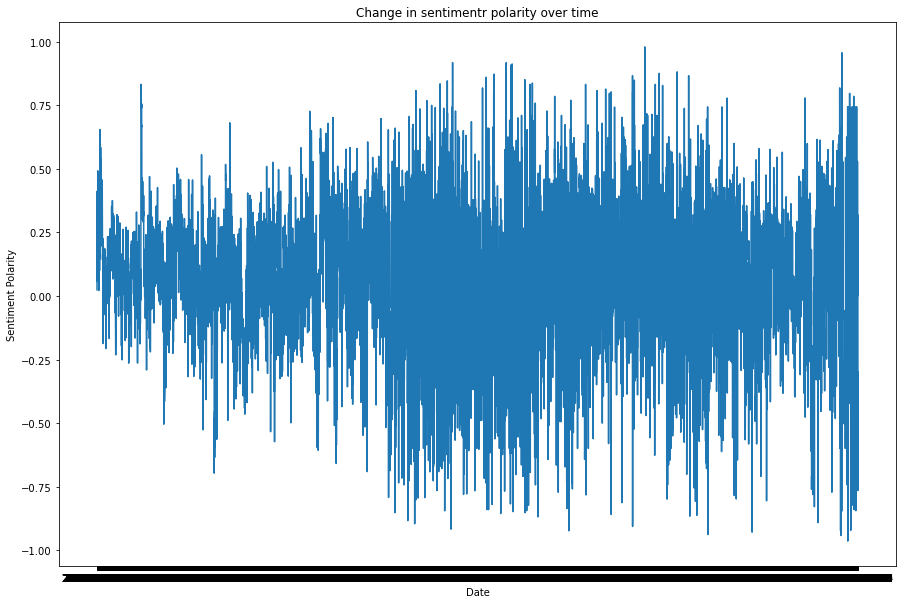

In [3]:
#plotting the polarity asd a function of time
import seaborn as sns
import matplotlib.pyplot as plt
#timeseries_df['datetime'] = timeseries_df['date'] + timeseries_df['hour']

plt.figure(figsize=(15, 10))

sns.lineplot(data = timeseries_df, x = 'datetime', y = 'hourly_polarity')
plt.xlabel('Date')
plt.ylabel('Sentiment Polarity')
plt.title('Change in sentimentr polarity over time')
plt.show()

The period of the signal is 3398.9999999999995 hours
5099
5097


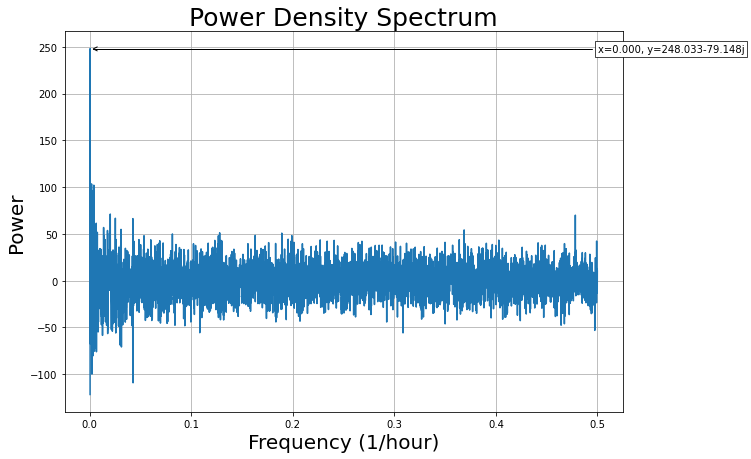

In [28]:
#find the period of any seasonality in my data using a fft method seen in my last ca, this is needed to find out what period value to use in seasonal decompose
import numpy as np

def seasonality(series, mult):
    #extracting the data from the spark dataframe
    rain = series

    #using the fourier transform to find the period of the signal
    rain_fft = np.fft.rfft(rain)*mult
    rain_frequency = np.fft.rfftfreq(len(rain))

    #code to find max value and annotate the plot "https://stackoverflow.com/questions/10366520/matplotlib-annotate-a-point-with-maximum-y-value" Code used from here, no need to re-invent the wheel
    def annot_max(x,y, ax=None):
        xmax = x[np.argmax(y)]
        ymax = y.max()
        text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
        if not ax:
            ax=plt.gca()
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
        kw = dict(xycoords='data',textcoords="data",
                  arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
        ax.annotate(text, xy=(xmax, ymax), xytext=(xmax+.5,ymax+5), **kw)
        print(f'The period of the signal is {1/(xmax)} hours') 

    #plotting the data
    plt.figure(figsize=(10, 7))
    plt.plot(rain_frequency[2:], rain_fft[2: ])
    annot_max(rain_frequency[2:], rain_fft[2: ])
    print(len(rain_frequency))
    print(len(rain_frequency[2:]))
    plt.xlabel('Frequency (1/hour)', fontsize = 20)
    plt.ylabel('Power', fontsize = 20)
    plt.title('Power Density Spectrum', fontsize = 25)
    plt.grid()
    plt.show()

seasonality(timeseries_df['hourly_polarity'], 1)

There is a period of 3400 hours or 141.66 days

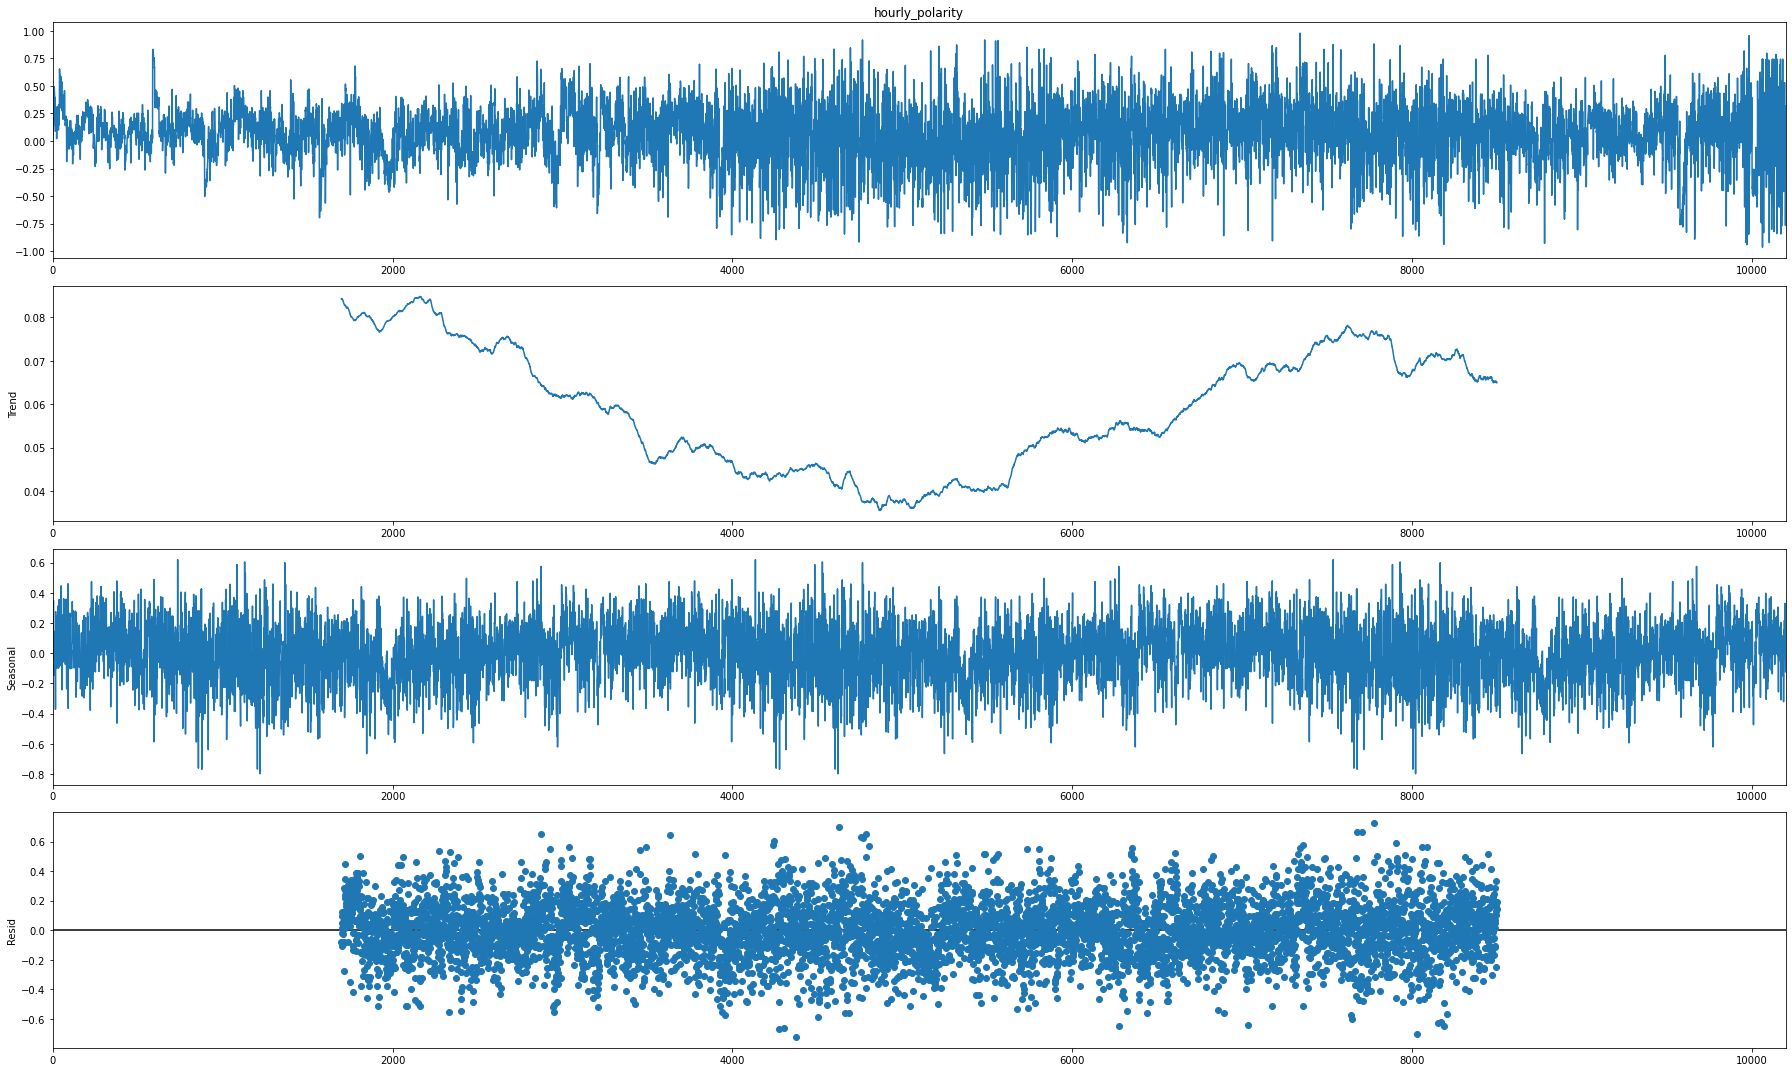

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = (25,15)
result = seasonal_decompose(timeseries_df['hourly_polarity'], model='additive', period = 3399)
result.plot()
plt.show()



In [30]:
#there is no noticable seasonality in the data, we will double check this using the ADF
#there is trend, going down then appearing to go up

In [7]:
from statsmodels.tsa.stattools import kpss
result = kpss(timeseries_df['hourly_polarity'])
if result[1] > 0.05:
    print('the data is stationary')
if result[1] < 0.05:
    print('the data is not stationary')
    
print(result[1])


the data is not stationary
0.047785998341642724


In [32]:
#since this data is not stationary we will difference the data and try againb
timeseries_df['polarity_diff'] = timeseries_df['hourly_polarity'].diff()
timeseries_df = timeseries_df.iloc[1: , :]
timeseries_df.head()

Unnamed: 0        date  hour  hourly_polarity      datetime  polarity_diff
1           2  2022-02-24     8         0.151148  2022-02-2408       0.127379
2           3  2022-02-24     9         0.056736  2022-02-2409      -0.094411
3           4  2022-02-24    10         0.411610  2022-02-2410       0.354874
4           5  2022-02-24    11         0.406074  2022-02-2411      -0.005536
5           6  2022-02-24    12         0.131907  2022-02-2412      -0.274167

In [33]:
result = kpss(timeseries_df['polarity_diff'])
if result[1] > 0.05:
    print('the data is stationary')
if result[1] < 0.05:
    print('the data is not stationary')
    
print(result[1])

the data is stationary
0.1


/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


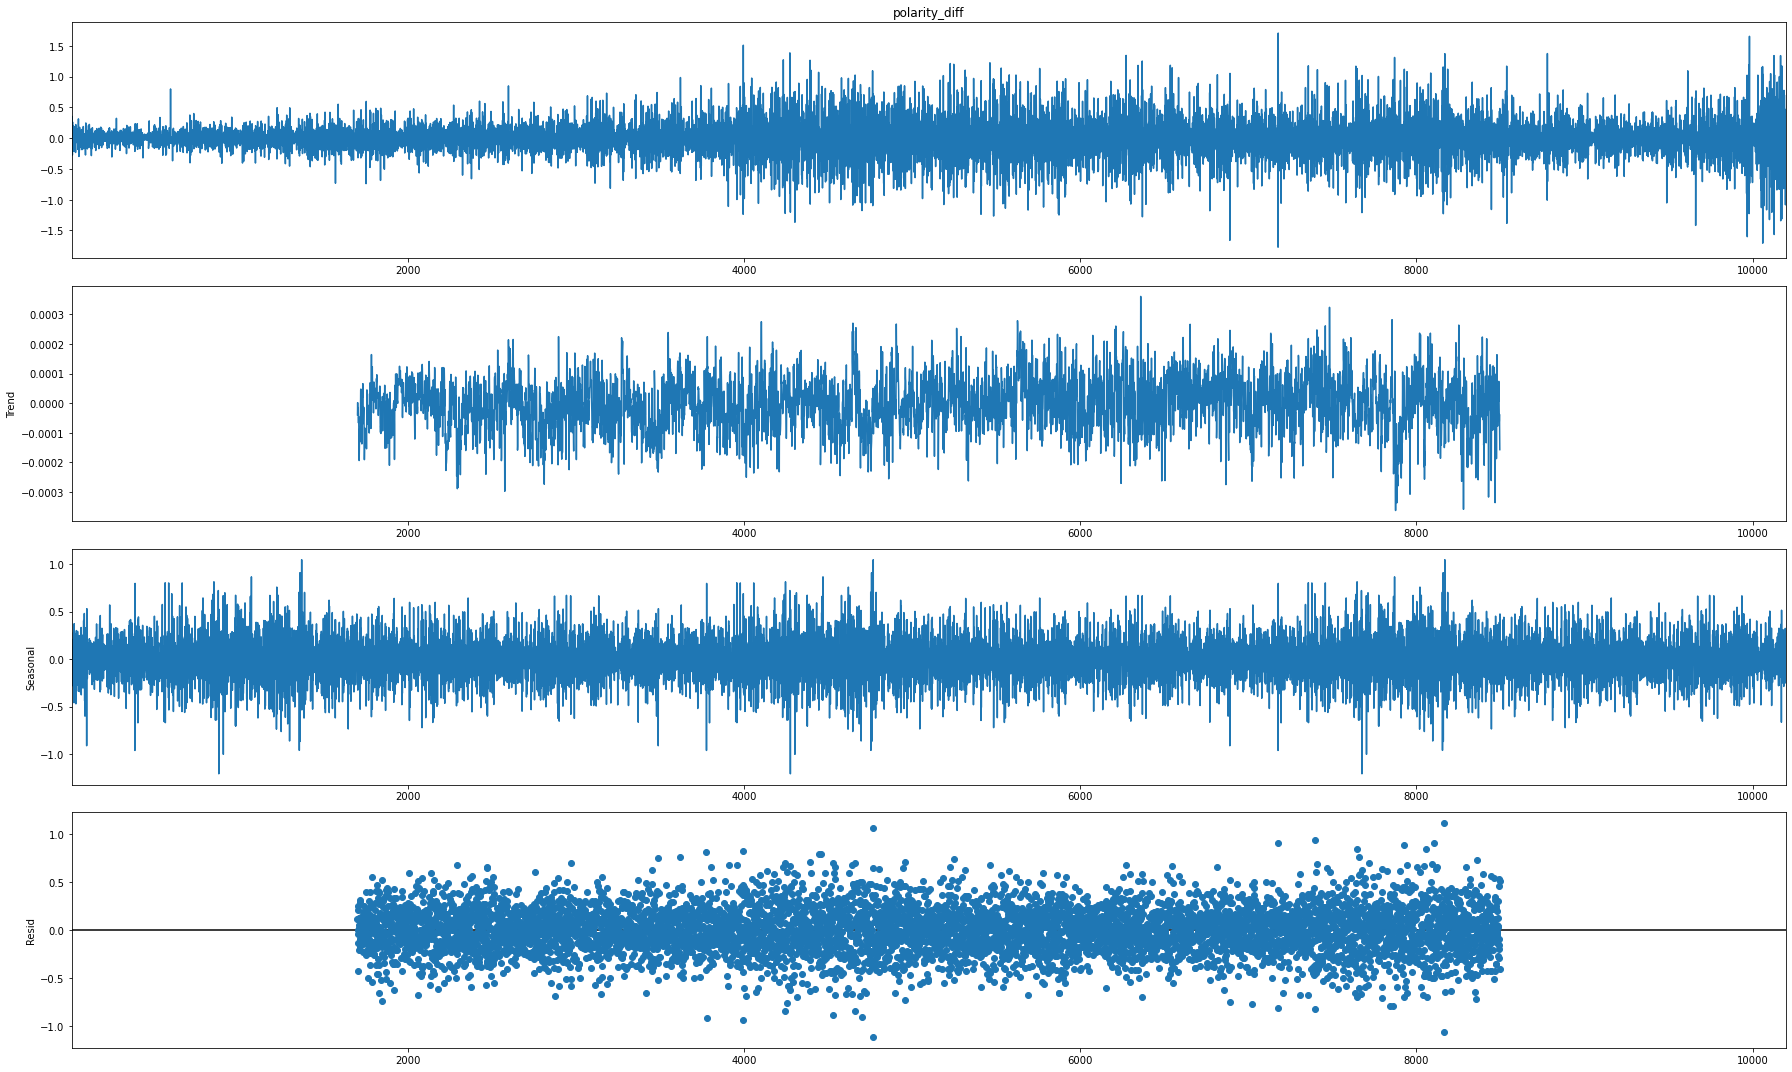

In [34]:
plt.rcParams['figure.figsize'] = (25,15)
result = seasonal_decompose(timeseries_df['polarity_diff'], model='additive', period = 3400)
result.plot()
plt.show()

#great the non-stationarity is gone



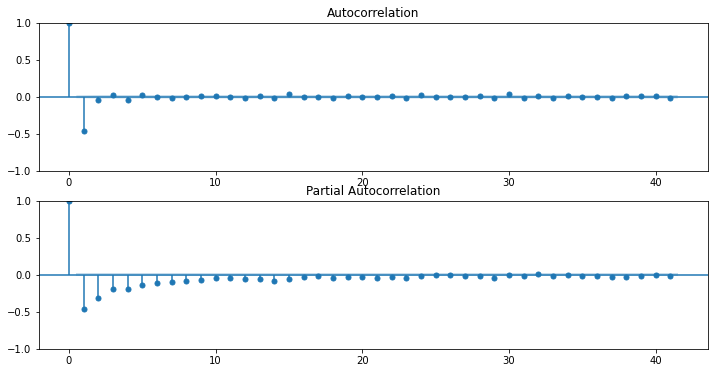

In [35]:
#programminbg a brute force gridsearch style method to finding opt parameters for ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Assuming you have a DataFrame df and 'column_name' is the name of the column containing your time series data
data = timeseries_df['polarity_diff']

fig, ax = plt.subplots(2, figsize=(12,6))

# Plot ACF
plot_acf(data, ax=ax[0])

# Plot PACF
plot_pacf(data, ax=ax[1])

plt.show()



p = 1
q = 2
d = 1(first order differencing)

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
forecast = SARIMAX(timeseries_df['hourly_polarity'], order = (1,1,2), seasonal_order = (1,1,2,6))#chose 6 for half year period(nearly)
forecast_fit = forecast.fit()
forecast_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77251D-01    |proj g|=  4.09264D-01

At iterate    5    f=  3.20428D-02    |proj g|=  1.52963D-01

At iterate   10    f=  1.66755D-02    |proj g|=  7.48793D-02

At iterate   15    f=  3.24882D-03    |proj g|=  7.43327D-02

At iterate   20    f=  1.66259D-03    |proj g|=  1.43877D-02

At iterate   25    f=  1.52774D-03    |proj g|=  8.52446D-03

At iterate   30    f=  4.88548D-04    |proj g|=  3.29105D-02

At iterate   35    f= -2.46502D-03    |proj g|=  4.77866D-02

At iterate   40    f= -4.06312D-03    |proj g|=  1.69308D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                   hourly_polarity   No. Observations:                10196
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 6)   Log Likelihood                  41.428
Date:                           Wed, 24 May 2023   AIC                            -68.855
Time:                                   21:50:09   BIC                            -18.252
Sample:                                        0   HQIC                           -51.742
                                         - 10196                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7731      0.025     31.323      0.000       0.725       0.821
ma.L1         -1.5911      0.028    -57.034      0.000      -1.646      -1.536
ma.L2          0.6029      0.026     22.985      0.000       0.551       0.654
ar.S.L6       -1.0000      0.374     -2.671      0.008      -1.734      -0.266
ma.S.L6    -2.558e-05      0.085     -0.000      1.000      -0.166       0.166
ma.S.L12      -1.0000      0.664     -1.507      0.132      -2.301       0.301
sigma2         0.0580      0.017      3.452      0.001       0.025       0.091
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):              1519.36
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               2.87   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(-5.0, 5.0)

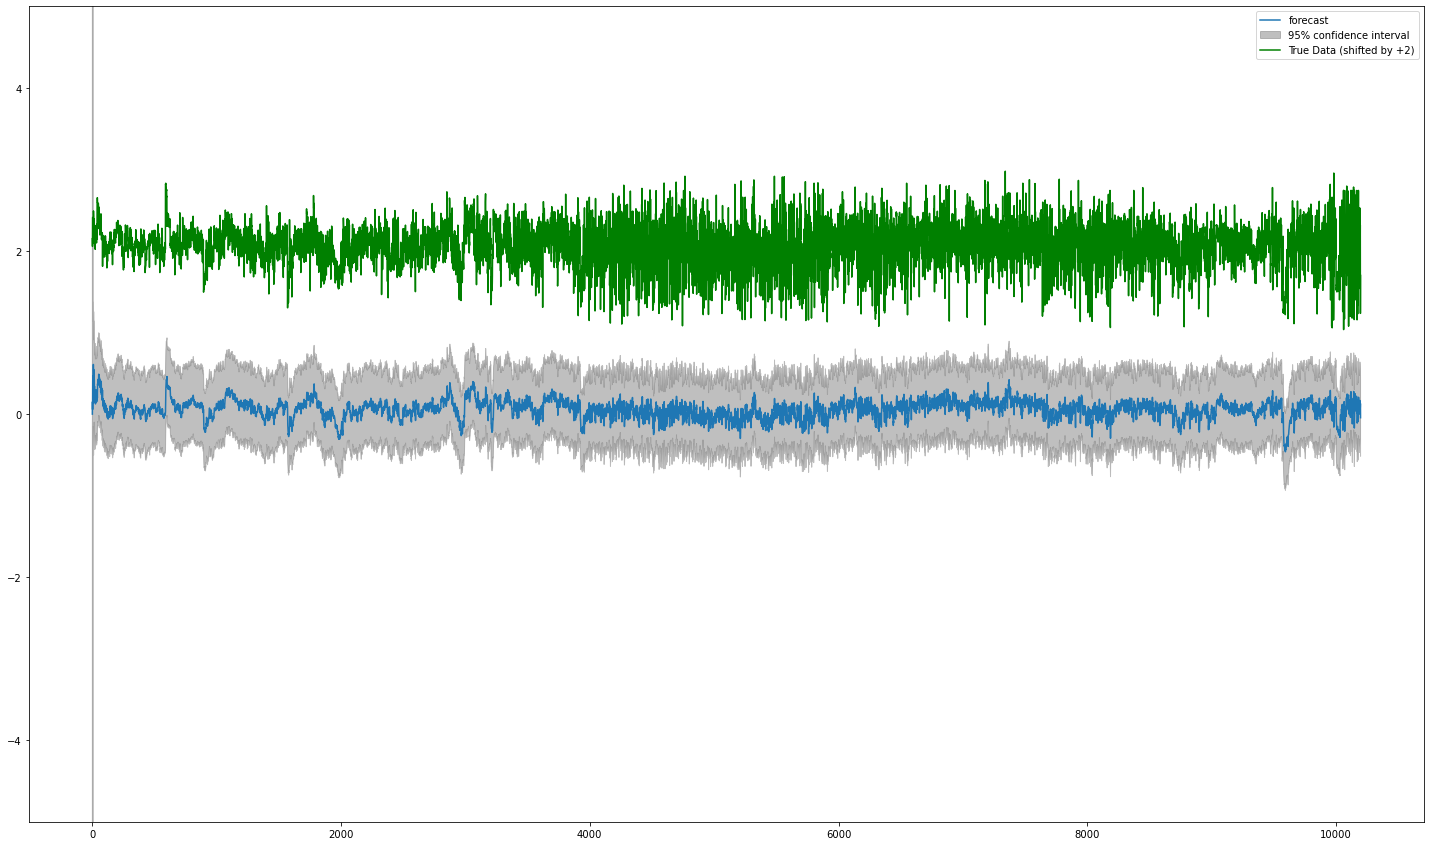

In [40]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(forecast_fit)
plt.plot(timeseries_df['hourly_polarity']+2, color = 'green', label = 'True Data (shifted by +2)')

plt.legend()
plt.ylim(-5,5)


In [41]:
forecast_1_week = forecast_fit.forecast(steps=7*24)
forecast_1_month = forecast_fit.forecast(steps=28*24)
forecast_3_month = forecast_fit.forecast(steps=28*3*24)



In [42]:
print(forecast_1_week)

10197   -0.065610
10198   -0.047866
10199   -0.020377
10200   -0.016879
10201   -0.001380
           ...   
10360    0.028138
10361    0.037508
10362    0.027076
10363    0.031789
10364    0.028859
Name: predicted_mean, Length: 168, dtype: float64


[]

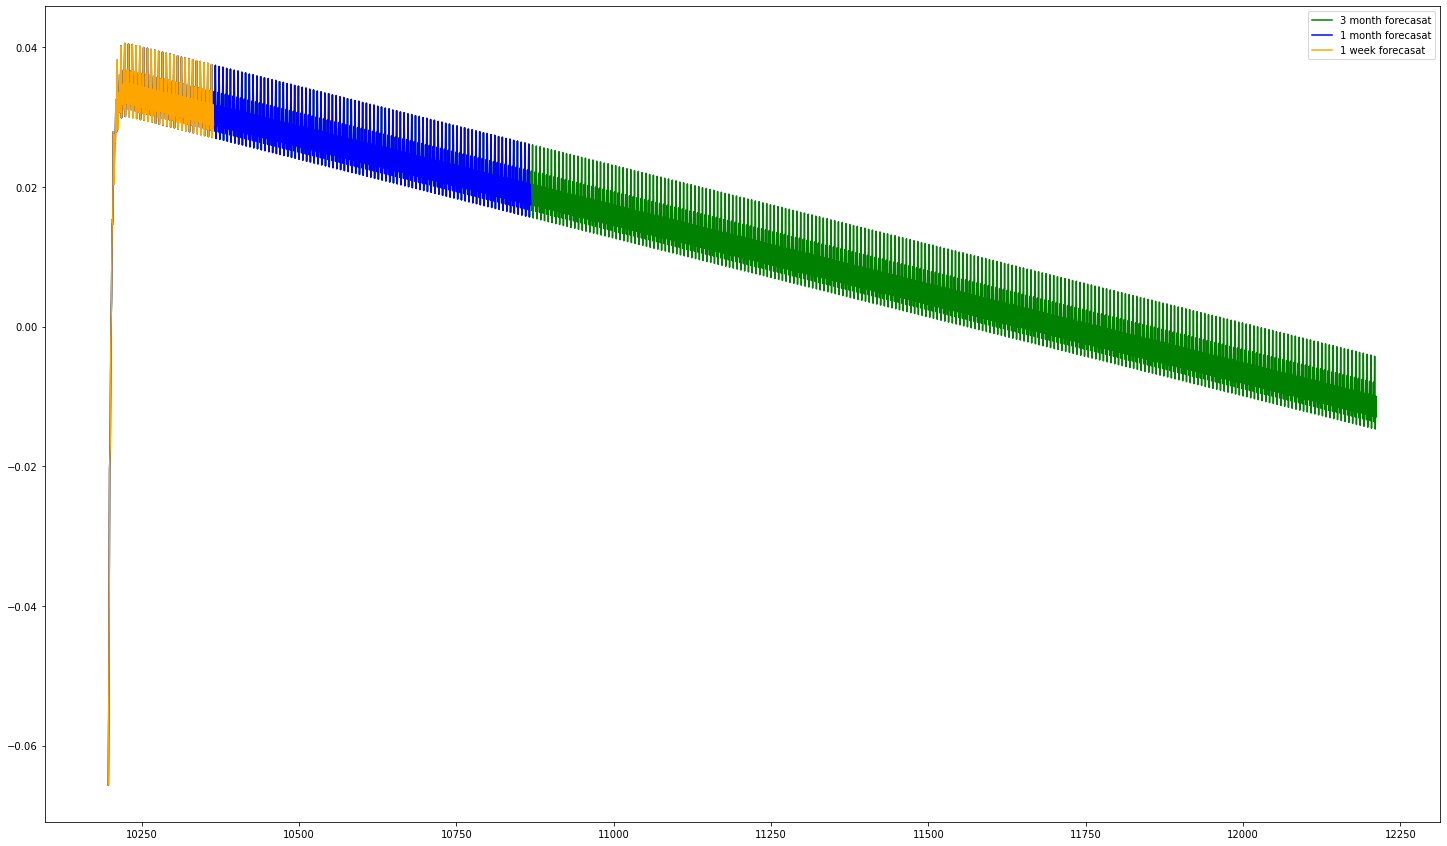

In [47]:
plt.plot(forecast_3_month, label = '3 month forecasat', color = 'green')
plt.plot(forecast_1_month, label = '1 month forecasat', color = 'blue')
plt.plot(forecast_1_week, label = '1 week forecasat', color = 'orange')

plt.legend()
plt.plot()

In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
timeseries_df = pd.read_csv('Timeseries_Data.csv')

In [ ]:
#using auto_arima to fit timeseries

import numpy as np
import pmdarima as pm